In [83]:
import os
import re
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from timeit import default_timer as timer
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import kagglehub
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter

from torch.utils.data import TensorDataset, DataLoader, random_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Activation, MaxPooling1D, Dropout
from tensorflow.keras.utils import plot_model, to_categorical
import tensorflow as tf

# MAPPING DATASETS

In [ ]:
# Map Kaggle and Mendeley labels to unified set
label_map = {
    "URTI": "URTI",
    "Healthy": "Healthy",
    "Asthma": "Asthma",
    "COPD": "COPD",
    "LRTI": "LRTI",
    "Pneumonia": "Pneumonia",
    "Bronchiectasis": "BRON",
    "Bronchiolitis": "BRON",
    "BRON": "BRON",
    "Lung Fibrosis":"Lung Fibrosis",
    "Plueral Effusion":"Plueral Effusion"
}

In [11]:
class Diagnosis():
  def __init__ (self, id, diagnosis, audio_path):
    self.id = id
    self.diagnosis = diagnosis 
    self.audio_path = audio_path   

# CLEANING & PARSING: Mendeley Dataset

In [12]:
# extract labels for Mendeley dataset
path_mendeley = "audioDataMendeley/Audio files"

keep_upper = {"COPD", "BRON"}
diagnosis_list =[]

# Detect diagnosis text in the filename and format it properly.
def format_diagnosis_from_filename(filename):
    name, ext = os.path.splitext(filename)
    
    # Split on first underscore
    parts = name.split("_", 1)
    if len(parts) > 1:
        prefix, diag_segment = parts[0], parts[1]
        
        # Split the diagnosis segment by commas
        diag_parts = diag_segment.split(",")
        formatted_diag_parts = []
        for part in diag_parts:
            part_clean = part.strip()
            if part_clean.upper() in keep_upper:
                formatted_diag_parts.append(part_clean.upper())
            elif part_clean == "N":
                formatted_diag_parts.append("Healthy")
            else:
                formatted_diag_parts.append(part_clean.title())
        
        # Rejoin with commas
        new_diag_segment = ",".join(formatted_diag_parts)
        new_name = f"{prefix}_{new_diag_segment}"
    else:
        new_name = name
    
    return new_name + ext

# go through directory and only keep necessary files
mendeley_labels = []
data_mendeley = []
for c, file in enumerate(os.listdir(path_mendeley)):
    if file.endswith(".wav"):
        old_path = os.path.join(path_mendeley, file)

        if "heart failure" in file.lower() or "and" in file.lower():
            os.remove(old_path)
            continue

        new_filename = format_diagnosis_from_filename(file)
        new_path = os.path.join(path_mendeley, new_filename)
        
        # Rename the file
        os.rename(old_path, new_path)

        # make patient diagnosis csv
        filename_parts = new_filename.split("_")
        patient_id_pattern = r"\d+"

        # extract patient id and diagnosis from filename 
        match_id = re.search(patient_id_pattern,filename_parts[0])
        if match_id:
            patient_id_mendeley = int(match_id.group())

        diag_segment = filename_parts[1]
        patient_diagnosis_mendeley = diag_segment.split(",")[0].strip()
        
        data_mendeley.append([patient_id_mendeley,patient_diagnosis_mendeley])

        diagnosis_list.append(Diagnosis(
        id=c,
        diagnosis=patient_diagnosis_mendeley,
        audio_path=new_path
    ))
        
# export csv
patient_diagnosis_df_mendeley = pd.DataFrame(data_mendeley)
patient_diagnosis_df_mendeley.to_csv('audioDataMendeley/patient_diagnosis.csv', index=False)

# PARSING DATASET: Kaggle

In [13]:
# Download latest version of the database 
path = kagglehub.dataset_download("vbookshelf/respiratory-sound-database")

print("Path to dataset files:", path)

Path to dataset files: /Users/katherinebeaty/.cache/kagglehub/datasets/vbookshelf/respiratory-sound-database/versions/2


In [14]:
# extract lables for kaggle dataset
# Path to patient diagnosis CSV
diagnosis_path_kaggle = os.path.join(path, "Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv")

audio_path_kaggle = os.path.join(path, "Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/")
files_kaggle = []
for file in os.listdir(audio_path_kaggle):
    if file.endswith(".wav"):
        files_kaggle.append(file)

files_kaggle = sorted(files_kaggle)

In [ ]:
diag_dict_kaggle = { 101 : "URTI"}  
diagnosis_kaggle = pd.read_csv(diagnosis_path_kaggle)
  
for index , row in diagnosis_kaggle.iterrows():
    diag_dict_kaggle[row.iloc[0]] = row.iloc[1]

# Add kaggle files to diagnosis list
for c, f in enumerate(files_kaggle):
    patient_id = int(f.split('_')[0])
    raw_label = diag_dict_kaggle.get(patient_id, "Unknown")
    diagnosis_list.append(Diagnosis(
        id=c,
        diagnosis=label_map.get(raw_label, "Unknown"),
        audio_path=os.path.join(audio_path_kaggle, f)
    ))

# FEATURE EXTRACTION

In [ ]:
# Collect all audio files and diagnosises in sets
raw_audios = set(s.audio_path for s in diagnosis_list)
all_diagnosis = set(d.diagnosis for d in diagnosis_list)

In [43]:
print(raw_audios)

{'audioDataMendeley/Audio files/BP79_Asthma,E W,A R U,46,M.wav', '/Users/katherinebeaty/.cache/kagglehub/datasets/vbookshelf/respiratory-sound-database/versions/2/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/162_2b3_Ar_mc_AKGC417L.wav', '/Users/katherinebeaty/.cache/kagglehub/datasets/vbookshelf/respiratory-sound-database/versions/2/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/166_1p1_Al_sc_Meditron.wav', '/Users/katherinebeaty/.cache/kagglehub/datasets/vbookshelf/respiratory-sound-database/versions/2/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/107_2b5_Pr_mc_AKGC417L.wav', 'audioDataMendeley/Audio files/EP65_Asthma,E W,P R L,60,F.wav', 'audioDataMendeley/Audio files/EP53_Asthma,E W,P R M,72,F.wav', '/Users/katherinebeaty/.cache/kagglehub/datasets/vbookshelf/respiratory-sound-database/versions/2/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/145_2b2_Ar_mc_AKGC417L.wav', 'au

### Base Model

In [176]:
def extract_basic_model_features(audio_paths, target_sr=22050):
    # Load all audio files and return the audio file path, data, sample rate, and duration
    # Data is audio time series
    features = []

    for audio_file in audio_paths:
        y, sr = librosa.load(audio_file, sr=target_sr)  # sample rate is none bc of frequent low-frequency

        # compute STFT for chroma + contrast
        stft = np.abs(librosa.stft(y))

        # compute 1D audio features
        mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40), axis=1)
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr), axis=1)
        mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr), axis=1)
        contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sr), axis=1)
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr), axis=1)

        # concatenate all features into one 1D vector
        combined = np.concatenate((mfccs, chroma, mel, contrast, tonnetz))

        features.append(combined)

    # convert feature list to array (samples, feature_length)
    features = np.array(features)

    # pad along feature axis to ensure equal length
    max_len = max(f.shape[0] for f in features)
    padded = np.zeros((len(features), max_len))

    for i, f in enumerate(features):
        padded[i, :len(f)] = f

    # add channel dimension
    padded = padded[..., np.newaxis]  # shape: (samples, feature_length, 1)

    return padded


### Data Augmented Model

In [136]:
def augment_audio(audio, sr, augmentation_type):
    if augmentation_type == 'noise':
        noise = np.random.randn(len(audio))
        audio = audio + 0.005 * noise
        audio = np.clip(audio, -1.0, 1.0)
    elif augmentation_type == 'pitch_shift':
        audio = librosa.effects.pitch_shift(audio, sr=sr, n_steps=2)
    elif augmentation_type == 'remix':
        # detect non-silent intervals
        intervals = librosa.effects.split(audio, top_db=20)
        # only remix if there are multiple intervals
        if len(intervals) > 1:  
            np.random.shuffle(intervals)
            audio = librosa.effects.remix(audio, intervals)
        audio = np.clip(audio, -1.0, 1.0)
    return audio

In [201]:
def extract_augmented_model_features(audio_paths,target_sr =22050, n_mels=128,augmentation_types = ['noise','pitch_shift','time_stretch']):
    features = []
    # append original features to feature list
    all_audios = {}
    for audio_file in audio_paths:
        y, sr = librosa.load(audio_file,sr=target_sr) # sample rate is none bc of frequent low-frequency

        # compute STFT for chroma + contrast
        stft = np.abs(librosa.stft(y))

        # compute 1D audio features
        mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40), axis=1)
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr), axis=1)
        mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr), axis=1)
        contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sr), axis=1)
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr), axis=1)

        # concatenate all features into one 1D vector
        combined = np.concatenate((mfccs, chroma, mel, contrast, tonnetz))
        features.append(combined)

    # data augmentation loop
    for aug in augmentation_types:
        y_aug = augment_audio(y.copy(), sr, aug)
        stft_aug = np.abs(librosa.stft(y_aug))
        mfccs = np.mean(librosa.feature.mfcc(y=y_aug, sr=sr, n_mfcc=40), axis=1)
        chroma = np.mean(librosa.feature.chroma_stft(S=stft_aug, sr=sr), axis=1)
        mel = np.mean(librosa.feature.melspectrogram(y=y_aug, sr=sr), axis=1)
        contrast = np.mean(librosa.feature.spectral_contrast(S=stft_aug, sr=sr), axis=1)
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y_aug), sr=sr), axis=1)
        combined = np.concatenate((mfccs, chroma, mel, contrast, tonnetz))
        features.append(combined)

   # convert feature list to array (samples, feature_length)
    features = np.array(features)

    # pad along feature axis to ensure equal length
    max_len = max(f.shape[0] for f in features)
    padded = np.zeros((len(features), max_len))

    for i, f in enumerate(features):
        padded[i, :len(f)] = f

    # add channel dimension
    padded = padded[..., np.newaxis]  # shape: (samples, feature_length, 1)

    return padded

### Location Focused Model

In [197]:
def extract_location_metadata(filename):
# extract chest location of where recording was taken from
# important to note, some samples will not be looked at because they don't fit into mapping
    location_map = {
        # mendeley lables
        'A L': 'Anterior',
        'P L': 'Posterior',
        'A R': 'Anterior',
        'P R': 'Posterior',
        # kaggle labels
        'Al': 'Anterior',
        'Ar': 'Anterior',
        'Pl': 'Posterior',
        'Pr': 'Posterior',
        'Tc': 'Trachea',
        'Ll': 'Lateral Left',
        'Lr': 'Lateral Right'
    }
    if 'mendeley' in filename.lower():
        parts = filename.split(',')
        location_code_full = parts[-3].strip()
        if location_code_full != 'A U R':
            location_code = ' '.join(location_code_full.split()[:2])
            return location_map.get(location_code, 'Unknown')
        elif location_code_full == 'A U R':
            return 'Anterior'
    elif 'kaggle' in filename.lower():
        parts = filename.split('_')
        location_code = parts[-3]
        return location_map.get(location_code, 'Unknown')
    return 'Unknown'

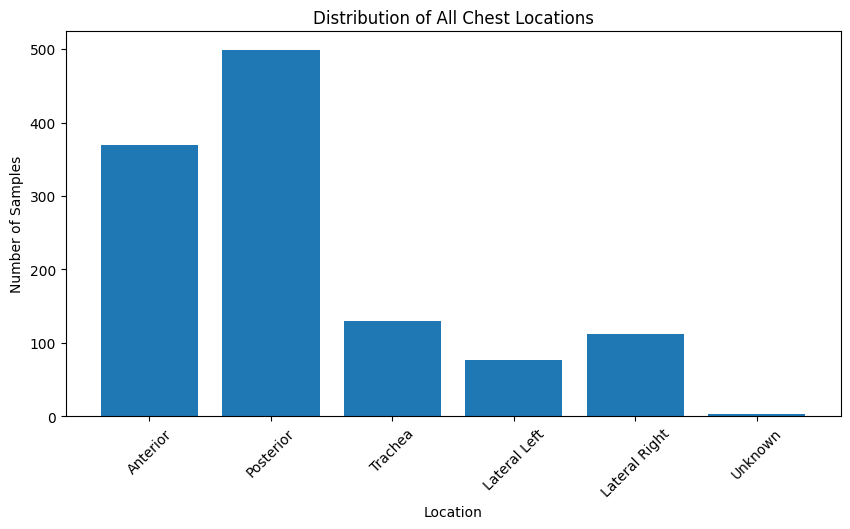

In [198]:
locations = [str(extract_location_metadata(f)) for f in raw_audios]
location_counts = Counter(locations)

# plot the distribution
plt.figure(figsize=(10,5))
plt.bar(location_counts.keys(), location_counts.values())
plt.xlabel('Location')
plt.ylabel('Number of Samples')
plt.title('Distribution of All Chest Locations')
plt.xticks(rotation=45)
plt.show()


We will not be using lateral, trachea, and unknown from our samples.

### Labels: string to int

In [116]:
unique_labels = sorted(set(d.diagnosis for d in diagnosis_list))

# Create a mapping from label
to_index = {label: idx for idx, label in enumerate(unique_labels)}
to_index

{'Asthma': 0,
 'BRON': 1,
 'COPD': 2,
 'Healthy': 3,
 'LRTI': 4,
 'Lung Fibrosis': 5,
 'Plueral Effusion': 6,
 'Pneumonia': 7,
 'URTI': 8}

### All labels and audio paths

In [117]:
audio_paths = [s.audio_path for s in diagnosis_list]
labels = [to_index[s.diagnosis] for s in diagnosis_list]

# PREPROCESSING

### Base and Augmented Model Splitting

In [118]:
# separate out the test set
train_val_paths, test_paths, y_train_val, y_test= train_test_split(
    audio_paths,labels, test_size=0.2, random_state=42, stratify=labels
)

# split the remaining paths into training and validation
train_paths, val_paths,y_train,y_val = train_test_split(
    train_val_paths, y_train_val,test_size=0.25, random_state=42, stratify=[labels[i] for i in range(len(train_val_paths))]
)

In [ ]:
# set labels to variables
train_labels = to_categorical(y_train, num_classes=9)
val_labels = to_categorical(y_val, num_classes=9)
test_labels = to_categorical(y_test, num_classes=9)

### Base Model Features

In [177]:
base_features_train = np.array(extract_basic_model_features(train_paths))
base_features_val = np.array(extract_basic_model_features(val_paths))
base_features_test = np.array(extract_basic_model_features(test_paths))

/Users/katherinebeaty/Documents/DS340 Project/.venv/lib/python3.11/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [179]:
print(base_features_train.shape) # 60%
print(base_features_val.shape) # 20%
print(base_features_test.shape) # 20%

(714, 193, 1)
(238, 193, 1)
(238, 193, 1)


### Data Augmented Model Features

In [ ]:
# extract features from paths for augmentation
augmented_features_train = np.array(extract_augmented_model_features(train_paths))
augmented_features_val = np.array(extract_augmented_model_features(val_paths))
augmented_features_test = np.array(extract_augmented_model_features(test_paths))

/Users/katherinebeaty/Documents/DS340 Project/.venv/lib/python3.11/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [ ]:
print(augmented_features_train.shape) # 60%
print(augmented_features_val.shape) # 20%
print(augmented_features_test.shape) # 20%

## Make CNN model bases

In [183]:
# Define model
def create_cnn_model1(input_shape,n_classes):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=5, activation='relu', input_shape=input_shape))
    model.add(Conv1D(128, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(256, kernel_size=5, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(9, activation='softmax'))

    # Compile model
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=[
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            tf.keras.metrics.F1Score(average='macro', threshold=0.5)
        ]
    )
    return model

In [186]:
# Define model; change = added dropout between conv layers and adjusted dropout values
def create_cnn_model2(input_shape,n_classes):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=5, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.25))
    model.add(Conv1D(128, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(256, kernel_size=5, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(9, activation='softmax'))

    # Compile model
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=[
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            tf.keras.metrics.F1Score(average='macro', threshold=0.5)
        ]
    )
    return model

In [187]:
# Define model; change = F1 now using weighted instead of macro
def create_cnn_model3(input_shape,n_classes):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=5, activation='relu', input_shape=input_shape))
    model.add(Conv1D(128, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(256, kernel_size=5, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(9, activation='softmax'))

    # Compile model
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=[
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            tf.keras.metrics.F1Score(average='weighted', threshold=0.5)
        ]
    )
    return model

# Modeling

### Run Base Model

In [ ]:
model = create_cnn_model1(input_shape=(base_features_train.shape[1], base_features_train.shape[2]), n_classes=9)
history = model.fit(
    base_features_train, 
    train_labels, 
    validation_data=(base_features_val, val_labels), 
    epochs=50, 
    batch_size=200
)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - f1_score: 0.0952 - loss: 11.6385 - precision_8: 0.5821 - recall_8: 0.4818 - val_f1_score: 0.1005 - val_loss: 6.4616 - val_precision_8: 0.4664 - val_recall_8: 0.4664
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - f1_score: 0.0946 - loss: 4.3378 - precision_8: 0.4696 - recall_8: 0.4104 - val_f1_score: 0.0811 - val_loss: 2.5499 - val_precision_8: 0.7437 - val_recall_8: 0.5000
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - f1_score: 0.0824 - loss: 1.7946 - precision_8: 0.7841 - recall_8: 0.4832 - val_f1_score: 0.0719 - val_loss: 1.4357 - val_precision_8: 0.8165 - val_recall_8: 0.3739
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - f1_score: 0.0730 - loss: 1.3171 - precision_8: 0.8691 - recall_8: 0.3627 - val_f1_score: 0.0669 - val_loss: 1.2825 - val_precision_8: 0.9036 - val_recall_8: 0.3151
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - f1_score: 0.0753 - loss: 1.1534 - precision_8: 0.8519 - recall_8: 0.3866 - val_f1_s

F1 Score: 89.00%
Precision: 74.79%
Recall: 24.81%
Loss: 0.5860


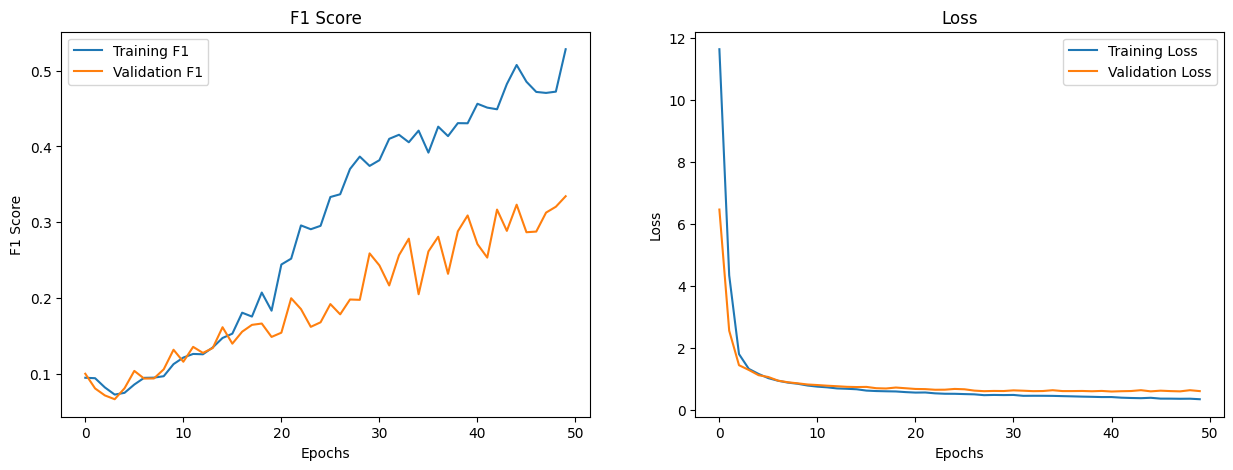

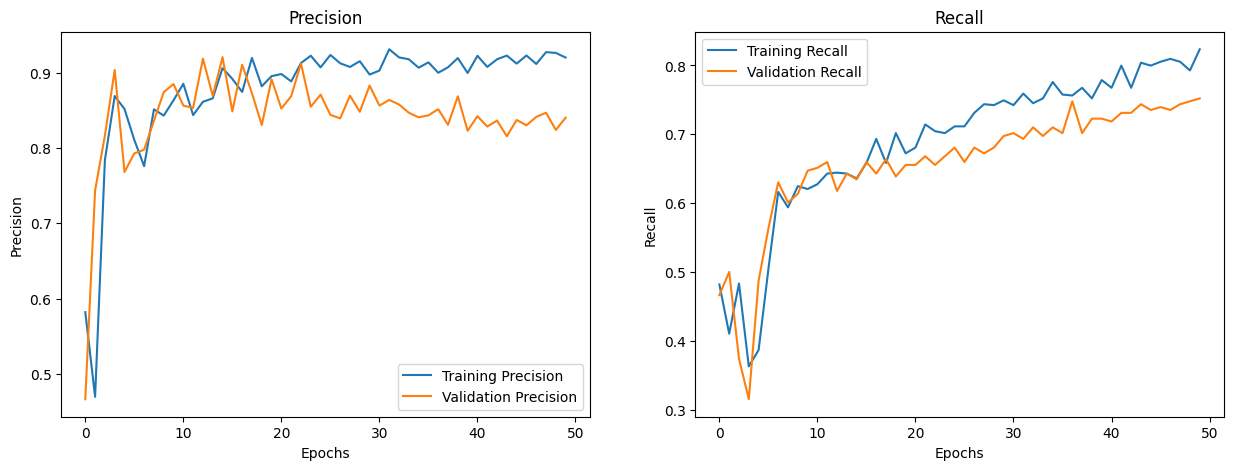

In [182]:
score = model.evaluate(base_features_test, test_labels, batch_size=60, verbose=0)
print(f"F1 Score: {score[1]:.2%}")
print(f"Precision: {score[2]:.2%}")
print(f"Recall: {score[3]:.2%}")
print("Loss: {:.4f}".format(score[0]))

# Plot F1 score and loss
plt.figure(figsize=(15, 5))

# F1 Score Plot
plt.subplot(1, 2, 1)
plt.title('F1 Score')
plt.plot(history.history['f1_score'], label='Training F1')
plt.plot(history.history['val_f1_score'], label='Validation F1')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.figure(figsize=(15, 5))

# Precision Score Plot
plt.subplot(1, 2, 1)
plt.title('Precision')
plt.plot(history.history['precision_8'], label='Training Precision')
plt.plot(history.history['val_precision_8'], label='Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Recall Score Plot
plt.subplot(1, 2, 2)
plt.title('Recall')
plt.plot(history.history['recall_8'], label='Training Recall')
plt.plot(history.history['val_recall_8'], label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.show()


In [188]:
model = create_cnn_model2(input_shape=(base_features_train.shape[1], base_features_train.shape[2]), n_classes=9)
history = model.fit(
    base_features_train, 
    train_labels, 
    validation_data=(base_features_val, val_labels), 
    epochs=50, 
    batch_size=200
)

Epoch 1/50


/Users/katherinebeaty/Documents/DS340 Project/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - f1_score: 0.0893 - loss: 10.1549 - precision_9: 0.5254 - recall_9: 0.4496 - val_f1_score: 0.0197 - val_loss: 17.0250 - val_precision_9: 0.0975 - val_recall_9: 0.0966
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - f1_score: 0.1069 - loss: 7.4974 - precision_9: 0.4392 - recall_9: 0.3796 - val_f1_score: 0.0858 - val_loss: 5.6572 - val_precision_9: 0.7165 - val_recall_9: 0.5840
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - f1_score: 0.0874 - loss: 4.8870 - precision_9: 0.7164 - recall_9: 0.5980 - val_f1_score: 0.0814 - val_loss: 3.6473 - val_precision_9: 0.7079 - val_recall_9: 0.5294
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - f1_score: 0.0840 - loss: 2.8075 - precision_9: 0.7436 - recall_9: 0.5280 - val_f1_score: 0.0738 - val_loss: 1.6988 - val_precision_9: 0.8158 - val_recall_9: 0.3908
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - f1_score: 0.0723 - loss: 1.5779 - precision_9: 0.8365 - recall_9: 0.3655 - val_f1_score: 0.01

F1 Score: 89.78%
Precision: 70.17%
Recall: 19.85%
Loss: 0.5897


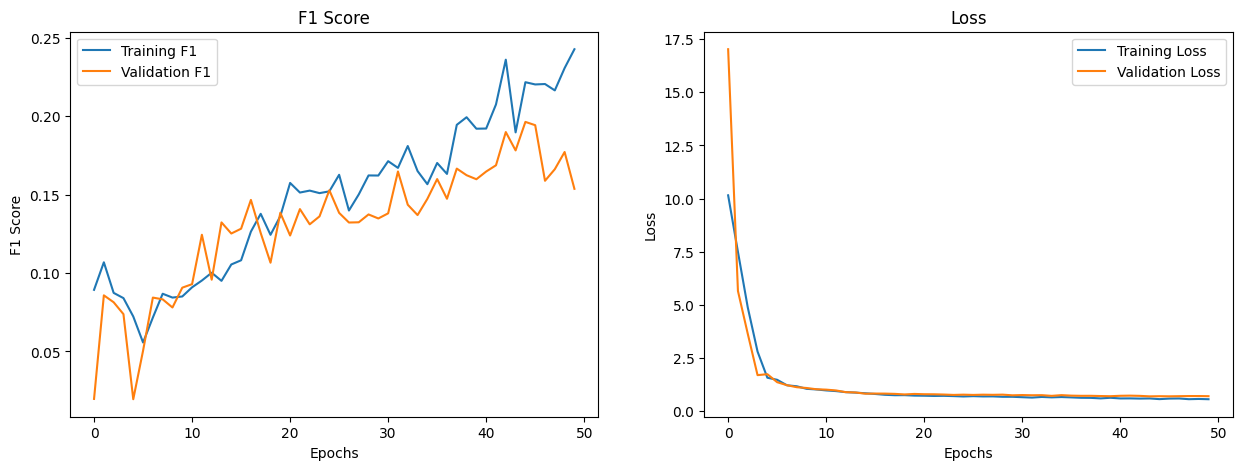

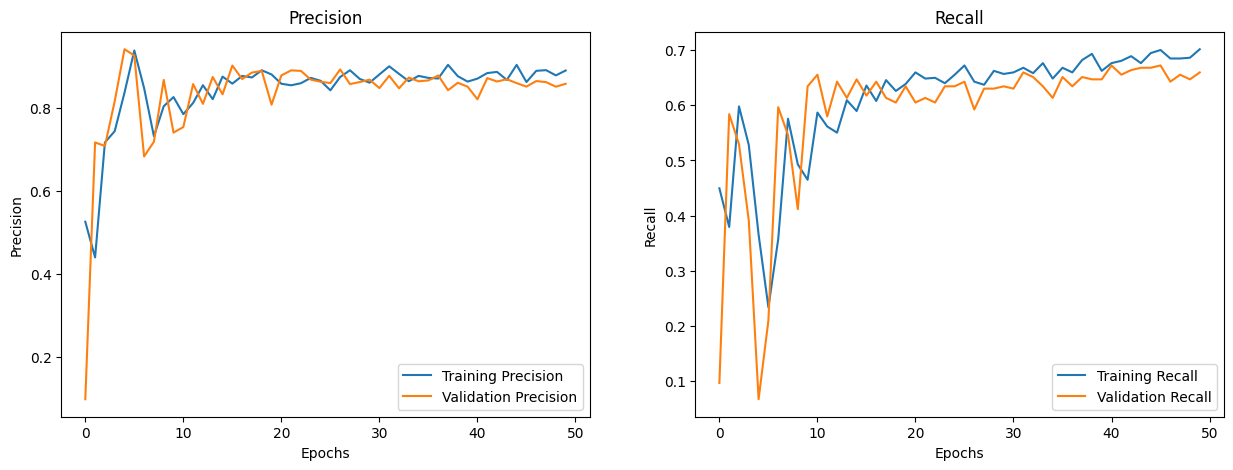

In [189]:
score = model.evaluate(base_features_test, test_labels, batch_size=60, verbose=0)
print(f"F1 Score: {score[1]:.2%}")
print(f"Precision: {score[2]:.2%}")
print(f"Recall: {score[3]:.2%}")
print("Loss: {:.4f}".format(score[0]))

# Plot F1 score and loss
plt.figure(figsize=(15, 5))

# F1 Score Plot
plt.subplot(1, 2, 1)
plt.title('F1 Score')
plt.plot(history.history['f1_score'], label='Training F1')
plt.plot(history.history['val_f1_score'], label='Validation F1')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.figure(figsize=(15, 5))

# Precision Score Plot
plt.subplot(1, 2, 1)
plt.title('Precision')
plt.plot(history.history['precision_9'], label='Training Precision')
plt.plot(history.history['val_precision_9'], label='Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Recall Score Plot
plt.subplot(1, 2, 2)
plt.title('Recall')
plt.plot(history.history['recall_9'], label='Training Recall')
plt.plot(history.history['val_recall_9'], label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.show()


In [190]:
model = create_cnn_model3(input_shape=(base_features_train.shape[1], base_features_train.shape[2]), n_classes=9)
history = model.fit(
    base_features_train, 
    train_labels, 
    validation_data=(base_features_val, val_labels), 
    epochs=50, 
    batch_size=200
)

Epoch 1/50


/Users/katherinebeaty/Documents/DS340 Project/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - f1_score: 0.5003 - loss: 8.0314 - precision_10: 0.5636 - recall_10: 0.4776 - val_f1_score: 0.0639 - val_loss: 15.3881 - val_precision_10: 0.1181 - val_recall_10: 0.1176
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - f1_score: 0.4560 - loss: 6.8949 - precision_10: 0.4427 - recall_10: 0.4062 - val_f1_score: 0.5395 - val_loss: 5.3777 - val_precision_10: 0.7143 - val_recall_10: 0.5882
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - f1_score: 0.5367 - loss: 4.1542 - precision_10: 0.7219 - recall_10: 0.5854 - val_f1_score: 0.5162 - val_loss: 2.8048 - val_precision_10: 0.7516 - val_recall_10: 0.5084
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - f1_score: 0.5102 - loss: 2.0167 - precision_10: 0.8312 - recall_10: 0.4552 - val_f1_score: 0.2754 - val_loss: 1.9205 - val_precision_10: 0.4945 - val_recall_10: 0.1891
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - f1_score: 0.4315 - loss: 1.4376 - precision_10: 0.8233 - recall_10: 0.3263 - v

F1 Score: 85.58%
Precision: 74.79%
Recall: 75.51%
Loss: 0.5788


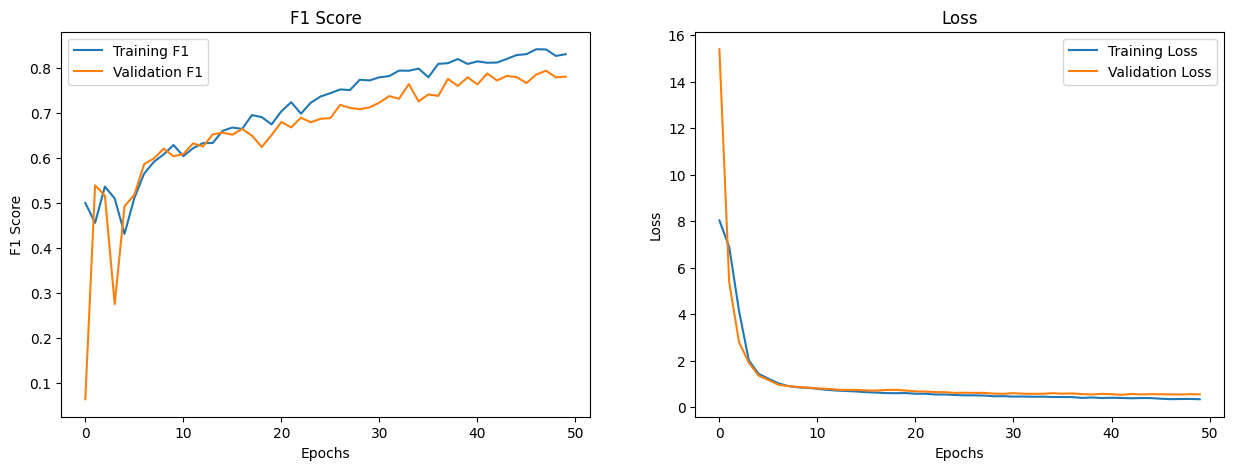

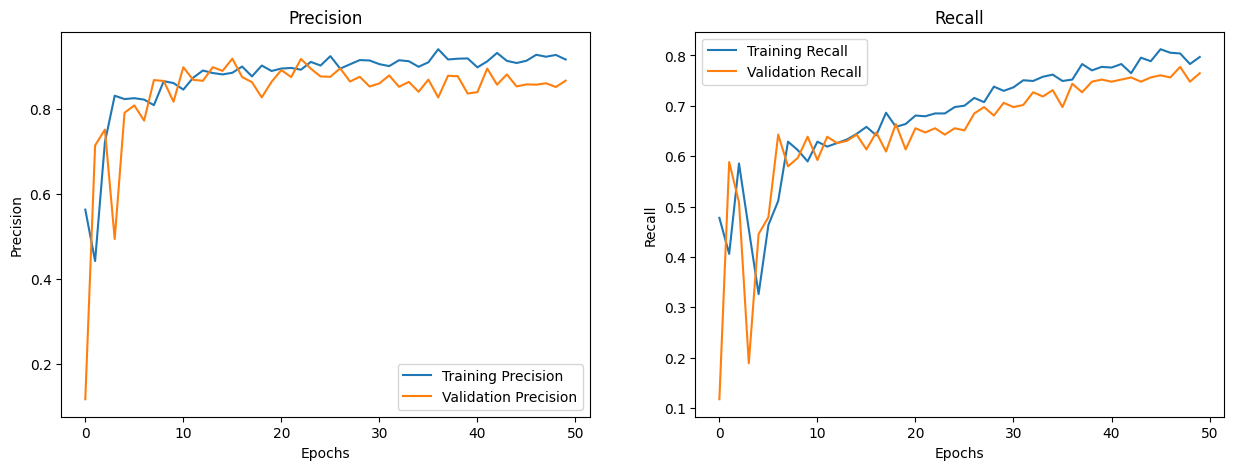

In [192]:
score = model.evaluate(base_features_test, test_labels, batch_size=60, verbose=0)
print(f"F1 Score: {score[1]:.2%}")
print(f"Precision: {score[2]:.2%}")
print(f"Recall: {score[3]:.2%}")
print("Loss: {:.4f}".format(score[0]))

# Plot F1 score and loss
plt.figure(figsize=(15, 5))

# F1 Score Plot
plt.subplot(1, 2, 1)
plt.title('F1 Score')
plt.plot(history.history['f1_score'], label='Training F1')
plt.plot(history.history['val_f1_score'], label='Validation F1')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.figure(figsize=(15, 5))

# Precision Score Plot
plt.subplot(1, 2, 1)
plt.title('Precision')
plt.plot(history.history['precision_10'], label='Training Precision')
plt.plot(history.history['val_precision_10'], label='Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Recall Score Plot
plt.subplot(1, 2, 2)
plt.title('Recall')
plt.plot(history.history['recall_10'], label='Training Recall')
plt.plot(history.history['val_recall_10'], label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.show()


### EXPERIMENT 1: Audio Distortion

### EXPERIMENT 2: Training of specific locations

In [200]:
locations = ['Anterior','Posterior']

results_locations = {}

for loc in locations:
    print(f'Training on {loc}')
    filtered_paths = [p for p in audio_paths if extract_location_metadata(p) == loc]
    filtered_labels = [labels[i] for i, p in enumerate(audio_paths) if extract_location_metadata(p) == loc]

    train_paths, test_paths, y_train, y_test = train_test_split(
        filtered_paths, filtered_labels, test_size=0.2, random_state=42, stratify=filtered_labels
    )
    train_paths, val_paths, y_train, y_val = train_test_split(
        train_paths, y_train, test_size=0.25, random_state=42, stratify=y_train
    )

    location_features_train = np.array(extract_basic_model_features(train_paths))
    location_features_val = np.array(extract_basic_model_features(val_paths))
    location_features_test = np.array(extract_basic_model_features(test_paths))

    y_train = to_categorical(y_train, num_classes=9)
    y_val = to_categorical(y_val,num_classes=9)
    y_test = to_categorical(y_test,num_classes=9)

    model = create_cnn_model1(input_shape=(base_features_train.shape[1], base_features_train.shape[2]), n_classes=9)
    history = model.fit(
        base_features_train, 
        train_labels, 
        validation_data=(base_features_val, val_labels), 
        epochs=50, 
        batch_size=200
    )

    score = model.evaluate(location_features_test, y_test, verbose=0)
    results_locations[loc] = {
        "loss": score[0],
        "precision": score[1],
        "recall": score[2],
        "f1_score": score[3]
    }

Training on Anterior


/Users/katherinebeaty/Documents/DS340 Project/.venv/lib/python3.11/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Epoch 1/50


/Users/katherinebeaty/Documents/DS340 Project/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 196ms/step - f1_score: 0.0860 - loss: 8.4792 - precision_11: 0.5674 - recall_11: 0.4776 - val_f1_score: 0.0330 - val_loss: 9.8476 - val_precision_11: 0.1387 - val_recall_11: 0.1387
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - f1_score: 0.1169 - loss: 4.4143 - precision_11: 0.4704 - recall_11: 0.4454 - val_f1_score: 0.1267 - val_loss: 4.4404 - val_precision_11: 0.6878 - val_recall_11: 0.5462
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - f1_score: 0.1129 - loss: 3.1756 - precision_11: 0.7383 - recall_11: 0.5294 - val_f1_score: 0.1044 - val_loss: 2.4928 - val_precision_11: 0.7357 - val_recall_11: 0.4328
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - f1_score: 0.0899 - loss: 1.8223 - precision_11: 0.8101 - recall_11: 0.4482 - val_f1_score: 0.0749 - val_loss: 1.3894 - val_precision_11: 0.8319 - val_recall_11: 0.3950
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - f1_score: 0.0775 - loss: 1.2337 - precision_11: 0.8917 - recall_11: 0.3922 - va

/Users/katherinebeaty/Documents/DS340 Project/.venv/lib/python3.11/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Epoch 1/50


/Users/katherinebeaty/Documents/DS340 Project/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 238ms/step - f1_score: 0.0899 - loss: 8.6310 - precision_12: 0.6098 - recall_12: 0.5056 - val_f1_score: 0.0521 - val_loss: 5.7452 - val_precision_12: 0.2059 - val_recall_12: 0.2059
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - f1_score: 0.1132 - loss: 3.5693 - precision_12: 0.4568 - recall_12: 0.4076 - val_f1_score: 0.0820 - val_loss: 3.1331 - val_precision_12: 0.7469 - val_recall_12: 0.5084
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - f1_score: 0.0832 - loss: 2.1255 - precision_12: 0.7655 - recall_12: 0.5028 - val_f1_score: 0.0746 - val_loss: 1.4897 - val_precision_12: 0.8378 - val_recall_12: 0.3908
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - f1_score: 0.0743 - loss: 1.3342 - precision_12: 0.8860 - recall_12: 0.3375 - val_f1_score: 0.0746 - val_loss: 1.1636 - val_precision_12: 0.8378 - val_recall_12: 0.3908
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - f1_score: 0.0842 - loss: 1.1266 - precision_12: 0.7868 - recall_12: 0.5014 - va

In [ ]:
locations = ['Anterior','Posterior']

results_locations_cnn3 = {}
history_cnn3 = {}

for loc in locations:
    print(f'Training on {loc}')
    filtered_paths = [p for p in audio_paths if extract_location_metadata(p) == loc]
    filtered_labels = [labels[i] for i, p in enumerate(audio_paths) if extract_location_metadata(p) == loc]

    train_paths, test_paths, y_train, y_test = train_test_split(
        filtered_paths, filtered_labels, test_size=0.2, random_state=42, stratify=filtered_labels
    )
    train_paths, val_paths, y_train, y_val = train_test_split(
        train_paths, y_train, test_size=0.25, random_state=42, stratify=y_train
    )

    location_features_train = np.array(extract_basic_model_features(train_paths))
    location_features_val = np.array(extract_basic_model_features(val_paths))
    location_features_test = np.array(extract_basic_model_features(test_paths))

    y_train = to_categorical(y_train, num_classes=9)
    y_val = to_categorical(y_val,num_classes=9)
    y_test = to_categorical(y_test,num_classes=9)

    model = create_cnn_model1(input_shape=(base_features_train.shape[1], base_features_train.shape[2]), n_classes=9)
    history = model.fit(
        base_features_train, 
        train_labels, 
        validation_data=(base_features_val, val_labels), 
        epochs=50, 
        batch_size=200
    )
    history_cnn3[loc] = history.history

    score = model.evaluate(location_features_test, y_test, verbose=0)
    results_locations[loc] = {
        "loss": score[0],
        "precision": score[1],
        "recall": score[2],
        "f1_score": score[3]
    }